In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error,accuracy_score
color_pal = sns.color_palette()

In [2]:
data = pd.read_csv("PJME_hourly.csv")

In [3]:
data

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [4]:
data.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [6]:
data.isna().sum()

Datetime    0
PJME_MW     0
dtype: int64

Type of Time series

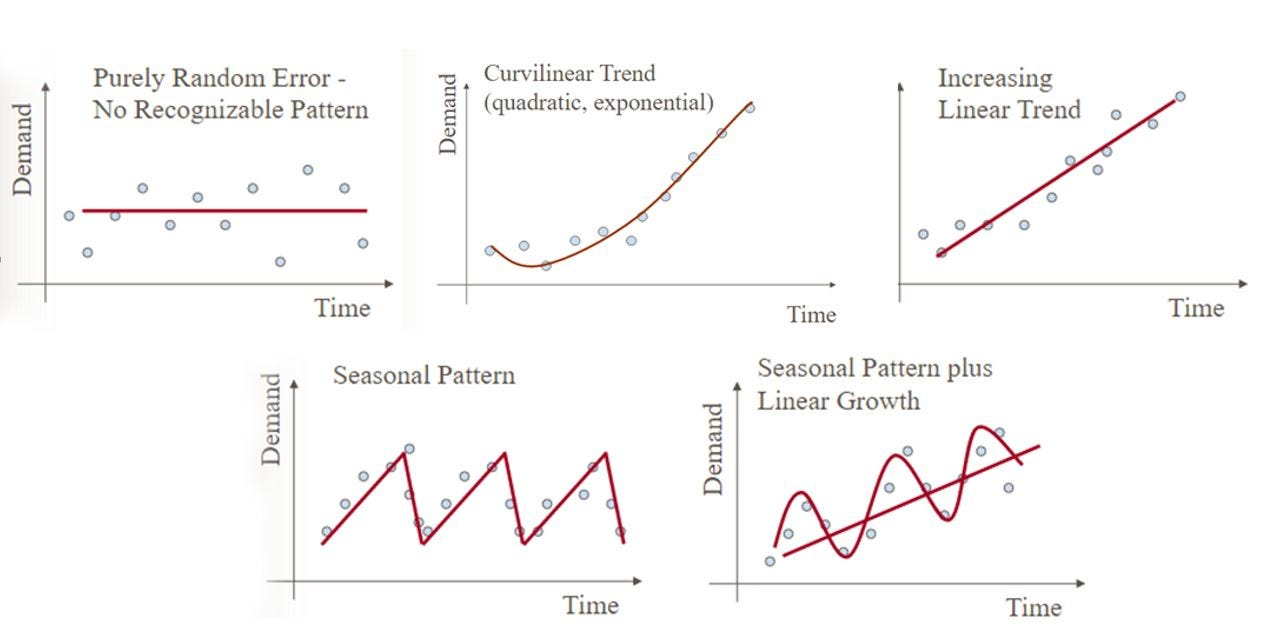

In [7]:
data

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [8]:
data = data.set_index('Datetime')

In [9]:
data

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [10]:
data.index = pd.to_datetime(data.index)

(<Axes: title={'center': 'PJME energy use in MW'}, xlabel='Datetime'>,)

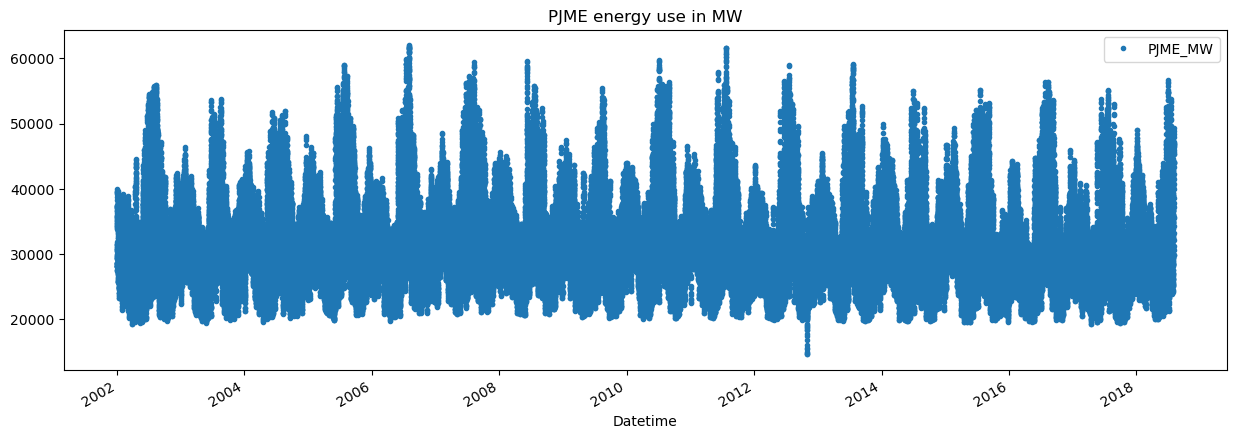

In [11]:
data.plot(style='.',figsize=(15,5),color = color_pal[0],title="PJME energy use in MW"),

In [12]:
data

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [13]:
data.dtypes

PJME_MW    float64
dtype: object

### Train test split

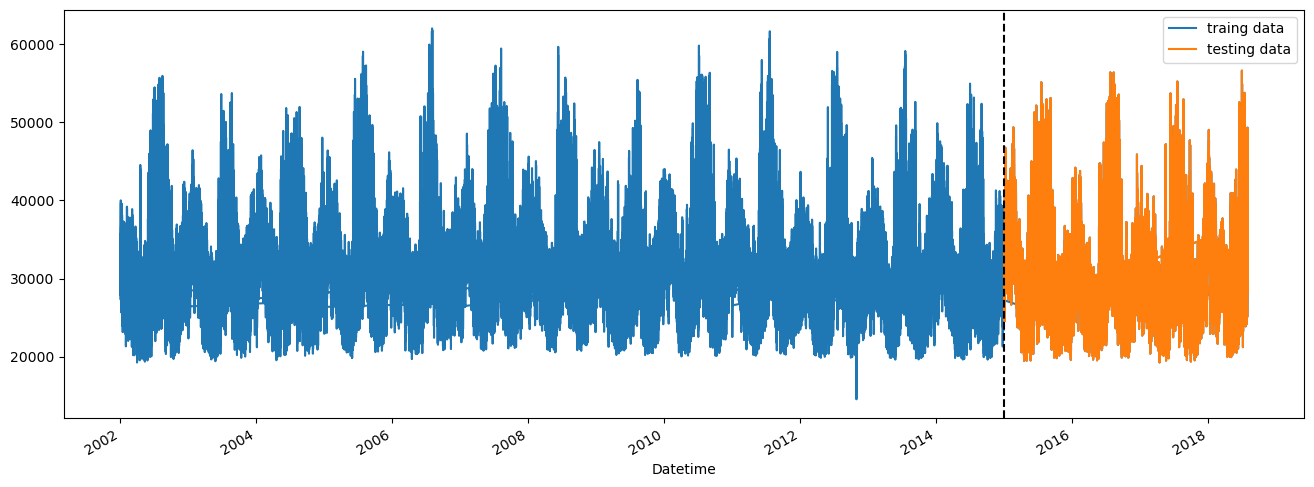

In [14]:
train = data.loc[data.index < '01-01-2025']
test = data.loc[data.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(16,6))
train.plot(ax=ax,label='train')
test.plot (ax=ax,label='test')
ax.axvline('01-01-2015',color='black',ls='--')
ax.legend(['traing data','testing data'])
plt.show()

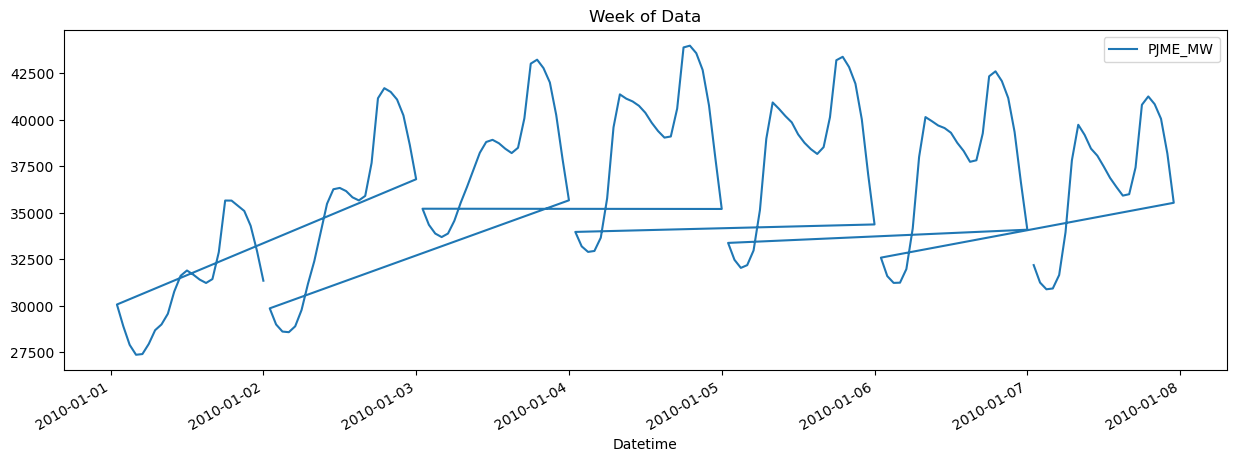

In [15]:
data.loc[(data.index > '01-01-2010') & (data.index < '01-08-2010')].plot(figsize =(15,5),title='Week of Data')
plt.show()

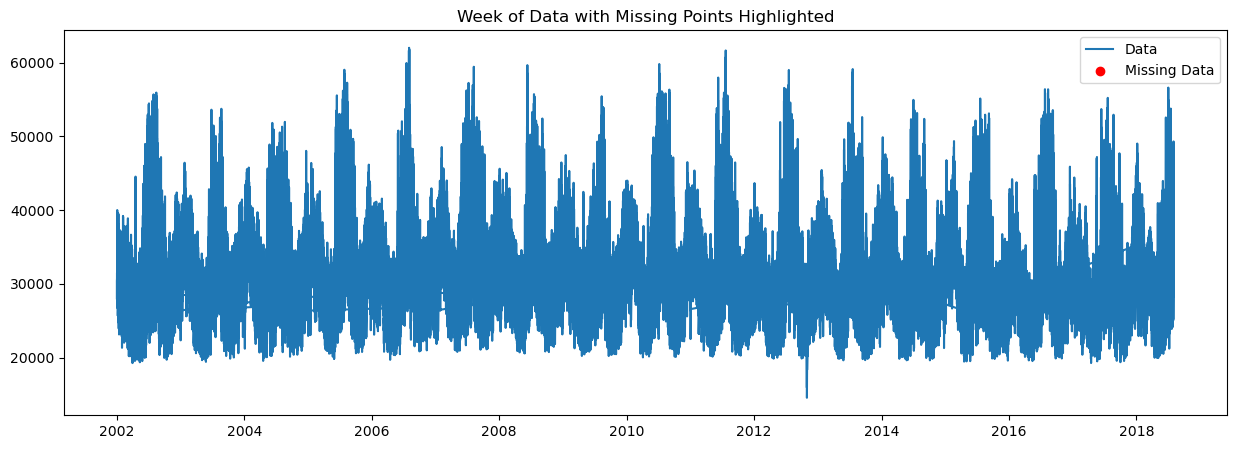

In [16]:
missing = data.isnull().any(axis=1)
plt.figure(figsize=(15, 5))
plt.plot(data.index, data['PJME_MW'], label='Data')
plt.scatter(data.index[missing], data['PJME_MW'][missing], color='red', label='Missing Data')
plt.title('Week of Data with Missing Points Highlighted')
plt.legend()
plt.show()

# feature creation 

Below we are creating a time series features based on time series index

In [19]:
def create_feature(df):
    df = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.day_of_week
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofyear'] = data.index.day_of_year
    return df

df = create_feature(df)

In [20]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


Text(0.5, 1.0, 'MW by Hour')

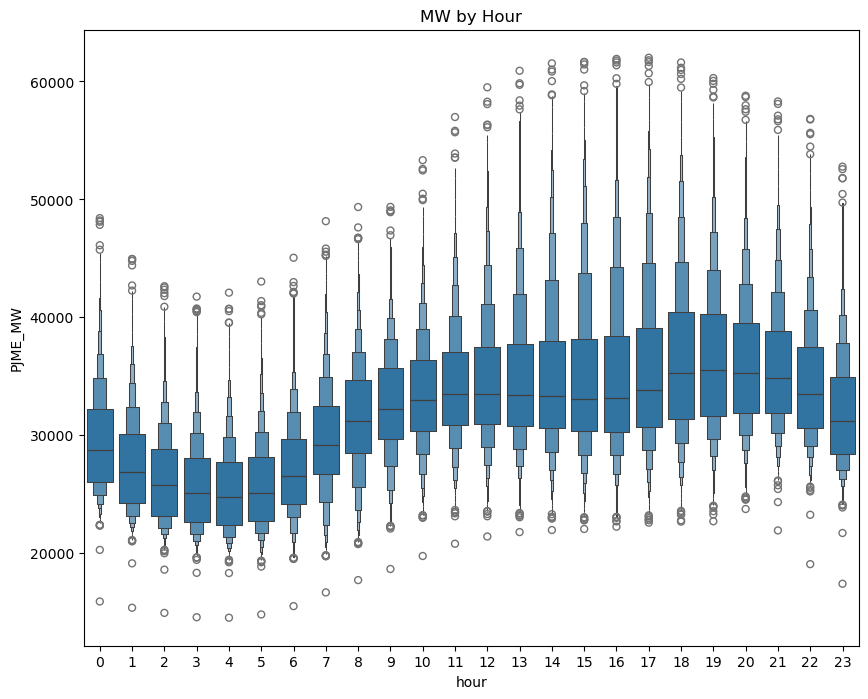

In [21]:
 ##Visulize our feature / target relationship
fig, ax=plt.subplots(figsize=(10,8))
sns.boxenplot(data=df , x='hour',y='PJME_MW')
ax.set_title('MW by Hour')

Text(0.5, 1.0, 'MW by Hour')

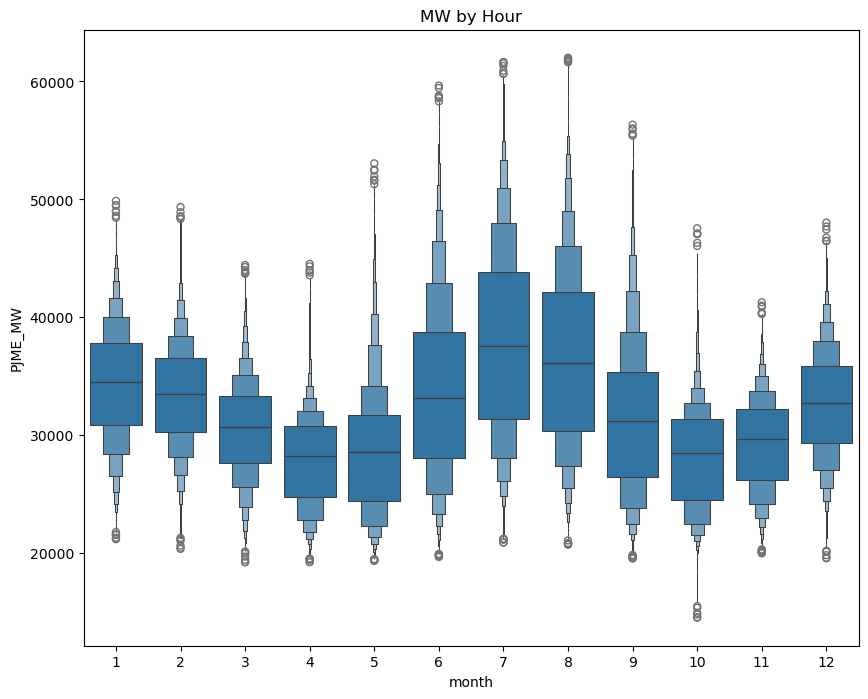

In [22]:
fig, ax=plt.subplots(figsize=(10,8))
sns.boxenplot(data=df , x='month',y='PJME_MW')
ax.set_title('MW by Hour')

In [23]:
train = create_feature(train)
test = create_feature(test)


In [24]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [25]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
target = 'PJME_MW'

In [26]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target] 

In [29]:
reg = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50,
    learning_rate=0.01)

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:6420.06782	validation_1-rmse:6420.06782
[1]	validation_0-rmse:6376.72587	validation_1-rmse:6376.72587
[2]	validation_0-rmse:6333.95656	validation_1-rmse:6333.95656
[3]	validation_0-rmse:6291.75579	validation_1-rmse:6291.75579
[4]	validation_0-rmse:6250.11898	validation_1-rmse:6250.11898
[5]	validation_0-rmse:6209.03331	validation_1-rmse:6209.03331
[6]	validation_0-rmse:6168.47167	validation_1-rmse:6168.47167
[7]	validation_0-rmse:6128.46840	validation_1-rmse:6128.46840
[8]	validation_0-rmse:6088.97469	validation_1-rmse:6088.97469
[9]	validation_0-rmse:6050.06380	validation_1-rmse:6050.06380
[10]	validation_0-rmse:6011.61074	validation_1-rmse:6011.61074
[11]	validation_0-rmse:5973.72704	validation_1-rmse:5973.72704
[12]	validation_0-rmse:5936.27167	validation_1-rmse:5936.27167
[13]	validation_0-rmse:5899.34368	validation_1-rmse:5899.34368
[14]	validation_0-rmse:5862.67946	validation_1-rmse:5862.67946
[15]	validation_0-rmse:5826.51440	validation_1-rmse:5826.51440
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_,columns=['importance'])

<Axes: title={'center': 'features Importace'}>

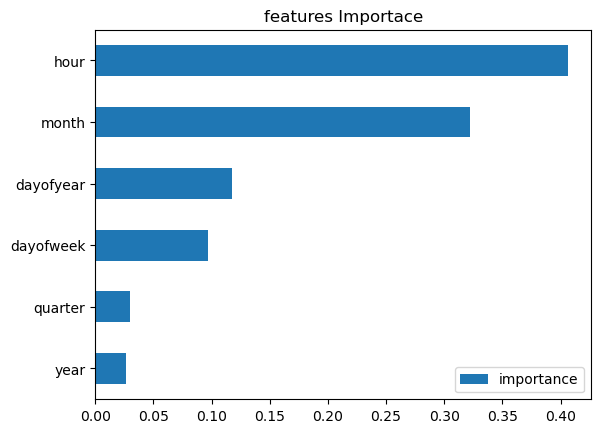

In [34]:
fi.sort_values('importance').plot(kind='barh',title="features Importace")

In [37]:
## Forcast

test['prediction'] = reg.predict(X_test)
test['prediction']

Datetime
2002-12-31 01:00:00    27715.406250
2002-12-31 02:00:00    26776.378906
2002-12-31 03:00:00    26260.185547
2002-12-31 04:00:00    26242.638672
2002-12-31 05:00:00    26536.544922
                           ...     
2018-01-01 20:00:00    43846.261719
2018-01-01 21:00:00    43475.757812
2018-01-01 22:00:00    41850.925781
2018-01-01 23:00:00    39934.613281
2018-01-02 00:00:00    38371.082031
Name: prediction, Length: 145366, dtype: float32

In [41]:
df = df.merge(test['prediction'],how="left",left_index=True,right_index=True)

In [43]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,27715.406250
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,26776.378906
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,26260.185547
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,26242.638672
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,26536.544922
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,43846.261719
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,43475.757812
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,41850.925781


In [45]:
score = np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))
score

2550.063689677634